In [1]:
import time
from collections import defaultdict
import numpy as np

import sys
import os
sys.path.append('../src')
from ice_graph.ice_graph import Ice_graph

import matplotlib.pyplot as plt



In [3]:
#Load the files (Note, you need to clone the repo first -- upper cells)
file_graphs = [dict(np.load(f'../example_data/{file}')) for file in sorted(os.listdir('../example_data')) if file[-3:]=='npz']
nextsim = Ice_graph(
    file_graphs,
    vertex_element_features =
        ['M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'M_VT_x',
        'M_VT_y',
        'x',
        'y']
)

In [6]:
vertex_i = 21000
time = 3


for i in range(nextsim.get_num_vertexs()):
    elements = np.where(nextsim.element_data_list[time]['t']==i)[0]
    if len(elements)==0:
        print("fail")


[48487 48490 48544 48567 48574 60383] [[21000 31803 37139]
 [69891 31803 21000]
 [ 4545 31038 21000]
 [69891 21000 31038]
 [21000 39610  4545]
 [39610 21000 37139]]


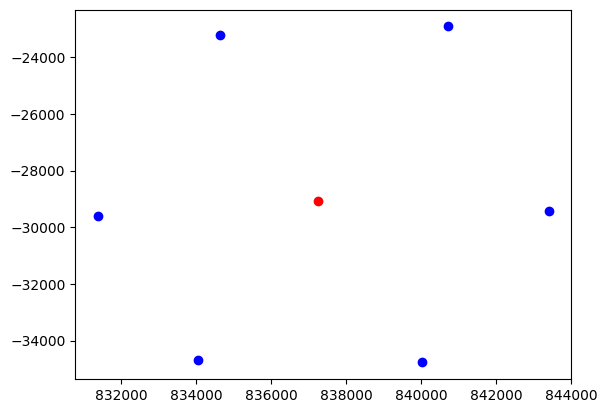

In [32]:
vertex_i = 21000
time = 3
tn = nextsim.get_tri_neighbors(time)
elements = np.where(np.isin(nextsim.element_data_list[time]['t'],vertex_i) )[0]
print(elements, nextsim.element_data_list[time]['t'][elements])

#plot the graph
x_e = nextsim.element_data_list[time]['x'][elements]
y_e = nextsim.element_data_list[time]['y'][elements]

x_v = nextsim.vertex_data_list[time]['x'][vertex_i]
y_v = nextsim.vertex_data_list[time]['y'][vertex_i]
plt.scatter(x_e,y_e,c='b')    
plt.scatter(x_v,y_v,c='r')


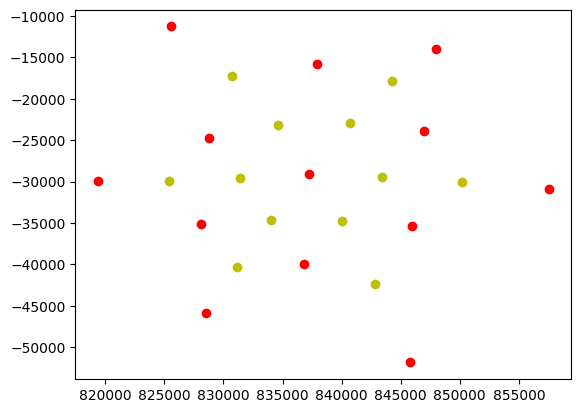

In [46]:
ee = tn.get_neighbors_many(elements,1)

x_ee = nextsim.element_data_list[time]['x'][ee]
y_ee = nextsim.element_data_list[time]['y'][ee]

vertexs = np.unique(nextsim.vertex_data_list[time]['t'][ee].flatten())

x_v = nextsim.vertex_data_list[time]['x'][vertexs]
y_v = nextsim.vertex_data_list[time]['y'][vertexs]  

plt.scatter(x_ee,y_ee,c='y')
plt.scatter(x_v,y_v,c='r')


In [16]:
class TriNeighbors:
    neighbors = None
    def __init__(self, t):
        elem2edge, edge2elem = self.get_edge_elem_relationship(t)
        # keep nearest neighbors for each element
        self.neighbors = []
        for i in range(t.shape[0]):
            neighbors_lists = [edge2elem[edge] for edge in elem2edge[i] if edge in edge2elem]
            neighbors_i = []
            for n1 in neighbors_lists:
                if len(n1) != 1:
                    for n2 in n1:
                        if n2 != i:
                            neighbors_i.append(n2)
            self.neighbors.append(neighbors_i)
        self.nneighbors = [len(n) for n in self.neighbors]
        
    def get_edge_elem_relationship(self, t):
        """ Create to maps: element to edge, and edge to element in one pass"""
        elem2edge = []
        edge2elem = defaultdict(list)
        for i, elem in enumerate(t):
            jj = [(elem[0], elem[1]), (elem[1], elem[2]), (elem[2], elem[0])]
            edges = [tuple(sorted(j)) for j in jj]
            elem2edge.append(edges)
            for edge in edges:
                edge2elem[edge].append(i)
        return elem2edge, edge2elem
    
    def get_neighbors(self, i, n=1, e=()):
        """ Get neighbors of element <i> crossing <n> edges

        Parameters
        ----------
        i : int, index of element
        n : int, number of edges to cross
        e : (int,), indeces to exclude

        Returns
        -------
        l : list, List of unique inidices of existing neighbor elements

        """
        # return list of existing immediate neigbours
        if n == 1:
            return self.neighbors[i]
        # recursively return list of neighbors after 1 edge crossing
        n2 = []
        for j in self.neighbors[i]:
            if j not in e:
                n2.extend(self.get_neighbors(j, n-1, e+(i,)))
        return list(set(self.neighbors[i] + n2))

    def get_neighbors_many(self, indices, n=1):
        """ Group neighbours of several elements """
        neighbors_many = [self.get_neighbors(i, n=n) for i in indices]
        return np.unique(np.hstack(neighbors_many)).astype(int)
    
    def get_distance_to_border(self):
        dist = np.zeros(len(self.neighbors)) + np.nan
        border = np.where(np.array(self.nneighbors) < 3)[0]
        dist[border] = 0

        d = 1
        while np.any(np.isnan(dist)):
            for i in np.where(dist == d - 1)[0]:
                neibs = self.get_neighbors(i)
                for j in neibs:
                    if np.isnan(dist[j]):
                        dist[j] = d
            d += 1
        return dist

In [15]:
file_graphs = [dict(np.load(f'../example_data/{file}')) for file in sorted(os.listdir('../example_data')) if file[-3:]=='npz']
nextsim = Ice_graph(
    file_graphs,
    vertex_element_features =
        ['M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'M_VT_x',
        'M_VT_y',
        'x',
        'y']
)
def get_neigh(idxs):
    n = []
    for i in idxs:
        n.append(nextsim.compute_vertex_neighbourhood(i)[0])

In [17]:
t = np.load('../example_data/field_20230101T000000Z.npz')['t']
t.shape

(138086, 3)

In [18]:
tn = TriNeighbors(t)
%timeit TriNeighbors(t)


537 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# only nearest neighbors (distance = 1 edge)
tn.get_neighbors(100, 1)

[102, 25758, 25764]

In [10]:
# all neighbors at distance <= 3 edges
tn.get_neighbors(100, 3)

[25792,
 25761,
 25791,
 135075,
 25764,
 100,
 102,
 135076,
 25767,
 25760,
 101,
 133805,
 135151,
 133848,
 25756,
 25757,
 25758,
 25759]

In [21]:
def get_neighbors(i, n=1):
    """ Get <n> neighbours for elemenets with indices in <i> """
    nn = []
    for j in i:
        nn.append(tn.get_neighbors(j))
    return nn

In [32]:
get_neighbors(range(100000))

[[138076, 136064],
 [133955, 133928, 135224],
 [135261, 135260, 135279],
 [135351, 135349, 4],
 [135610, 3, 135567],
 [135353, 135351, 135609],
 [135101, 732, 735],
 [135180, 734, 135100],
 [136120, 135100, 135179],
 [136098, 135180, 136120],
 [135117, 135103, 135102],
 [135117, 135158, 135174],
 [14, 135165, 135121],
 [135103, 135120, 135101],
 [135118, 12, 135103],
 [50, 36, 136112],
 [135326, 31, 135310],
 [55, 54, 56],
 [135337, 135326, 136125],
 [24, 136158, 135553],
 [136292, 136164, 136238],
 [23, 135306, 136158],
 [134953, 134954, 134951],
 [29, 21, 134952],
 [134957, 134952, 19],
 [44, 31, 30],
 [134951, 136192, 134952],
 [28, 136161, 136287],
 [42, 136188, 27],
 [136193, 23, 30],
 [25, 29, 136192],
 [16, 59, 25],
 [44, 136187, 135310],
 [136128, 136185, 135191],
 [136183, 135186, 48],
 [136278, 136113, 136112],
 [37, 15, 136182],
 [136279, 136278, 36],
 [60, 136312, 136108],
 [136118, 61, 136119],
 [136186, 46, 43],
 [136188, 136186, 136189],
 [136283, 136282, 28],
 [136189, 

In [33]:
get_neigh(range(100000))

KeyboardInterrupt: 

In [28]:
%timeit get_neigh(range(1000))

856 ms ± 7.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit get_neighbors([10])

142 ns ± 19.1 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [29]:
%timeit get_neighbors(range(1000))

49 µs ± 374 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%timeit get_neighbors(range(100))

16.8 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
%timeit get_neighbors(range(100000))

15.6 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
# get all neighbors at a distance <= 3 edges
%timeit get_neighbors(range(78000))

12.6 ms ± 990 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
len(get_neighbors(range(100000)))

100000